# Stacked Thermodynamic Profiles 3D (plain average)

In [2]:
#PART 1: Loadiing Packages

import yt
import pyxsim

import h5py
import numpy as np
import illustris_python as il
import glob

from tqdm import tqdmA
import os
from regions import RectangleSkyRegion
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy import wcs
from astropy.io import fits
import pylab as plt
from concurrent.futures import ProcessPoolExecutor, as_completed

ModuleNotFoundError: No module named 'yt'

In [ ]:
#PART 2: Simulation Specification
basePath = "../../../sims.TNG/TNG50-1/output/"
snap = 50                                                       #z=1
nbins = 10
r_norm_max = 2
max_workers = 3
tag = ["Efficient_AGN", "Efficient_Non", "Inefficient_AGN", "Inefficient_Non"]

In [ ]:
def process_single_halo(haloID, label):
    try:
        print(f"Processing {label} halo {haloID}...")
        halo = il.groupcat.loadSingle(basePath, snap, haloID=haloID)

        header = il.groupcat.loadHeader(basePath, snap)
        gas = il.snapshot.loadHalo(basePath, snap, haloID, "gas")
        with h5py.File(il.snapshot.snapPath(basePath, snap), 'r') as f:
            header_snap = dict(f['Header'].attrs)

        filename = f"halo_{label}_{haloID}.hdf5"
        with h5py.File(filename, 'w') as f:
            for key in gas.keys():
                f['PartType0/' + key] = gas[key]
            f.create_group('Header')
            f['Header'].attrs['NumFilesPerSnapshot'] = 1
            f['Header'].attrs['MassTable'] = header_snap['MassTable']
            f['Header'].attrs['BoxSize'] = header['BoxSize']
            f['Header'].attrs['Time'] = header['Time']
            f['Header'].attrs['Redshift'] = header['Redshift']
            f['Header'].attrs['NumPart_ThisFile'] = np.array([gas['count'],0,0,0,0,0])
            f['Header'].attrs['HubbleParam'] = header['HubbleParam']
            f['Header'].attrs['Omega0'] = header['Omega0']
            f['Header'].attrs['OmegaLambda'] = header['OmegaLambda']
            f['Header'].attrs['UnitLength_in_cm'] = header_snap['UnitLength_in_cm']
            f['Header'].attrs['UnitMass_in_g'] = header_snap['UnitMass_in_g']
            f['Header'].attrs['UnitVelocity_in_cm_per_s'] = header_snap['UnitVelocity_in_cm_per_s']

        ds = yt.load(filename)

        c = ds.arr(halo["GroupPos"], "code_length").to("kpc")
        r200 = ds.arr(halo["Group_R_Crit200"], "code_length").to("kpc")
        del halo, header, gas

        sp = ds.sphere(c, r_norm_max * r200)
        radii = np.linalg.norm(sp["PartType0", "Coordinates"].to("kpc") - c, axis=1) / r200
        #r_bins = np.linspace(0, r_norm_max, nbins + 1)
        r_bins = np.logspace(np.log10(1e-2), np.log10(r_norm_max), nbins + 1)

        def bin_profile(quantity):
            binned = np.array([
                np.mean(quantity[(radii >= r_bins[i]) & (radii < r_bins[i+1])])
                if np.any((radii >= r_bins[i]) & (radii < r_bins[i+1])) else np.nan
                for i in range(nbins)
            ])
            return np.nan_to_num(binned, nan=0.0)
            #return binned
        
        temp = bin_profile(sp["gas", "temperature"].to("K"))
        entropy = bin_profile(sp["gas", "entropy"].to("keV*cm**2"))
        pressure = bin_profile(sp["gas", "pressure"].to("dyne/cm**2"))
        density = bin_profile(sp["gas", "density"].to("g/cm**3"))
        sfr = bin_profile(sp["gas", "star_formation_rate"].to("g/s"))
        metal = bin_profile(sp["gas", "metallicity"])
        
        for f in [filename, filename + ".ewah"]:
            if os.path.exists(f):
                os.remove(f)

        return temp, entropy, pressure, density, sfr, metal

    except Exception as e:
        print(f"❌ Failed for halo {haloID}: {e}")
        return None

def combined_profiles(halo_list, label, hm):
    temp_all = []
    entropy_all = []
    pressure_all = []
    density_all = []
    sfr_all = []
    metal_all = []
                            
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_single_halo, haloID, label): haloID for haloID in halo_list}
        with tqdm(total=len(futures), desc=f"Processing {label} halos") as pbar:
            for future in as_completed(futures):
                result = future.result()
                if result:
                    t, e, p, d, s, m = result
                    temp_all.append(t)
                    entropy_all.append(e)
                    pressure_all.append(p)
                    density_all.append(d)
                    sfr_all.append(s)
                    metal_all.append(m)
                pbar.update(1)

    
    N = len(temp_all)

    np.savez(f"combined_hm{hm}_{label}.npz",
             temperature_mean=np.nanmean(temp_all, axis=0),
             temperature_sem=np.nanstd(temp_all, axis=0, ddof=1) / np.sqrt(N),
             entropy_mean=np.nanmean(entropy_all, axis=0),
             entropy_sem=np.nanstd(entropy_all, axis=0, ddof=1) / np.sqrt(N),
             pressure_mean=np.nanmean(pressure_all, axis=0),
             pressure_sem=np.nanstd(pressure_all, axis=0, ddof=1) / np.sqrt(N),
             density_mean=np.nanmean(density_all, axis=0),
             density_sem=np.nanstd(density_all, axis=0, ddof=1) / np.sqrt(N),
             sfr_mean=np.nanmean(sfr_all, axis=0),
             sfr_sem=np.nanstd(sfr_all, axis=0, ddof=1) / np.sqrt(N),
             metal_mean=np.nanmean(metal_all, axis=0),
             metal_sem=np.nanstd(metal_all, axis=0, ddof=1) / np.sqrt(N))

    print(f"✅ Saved combined_hm{hm}_{label}.npz")


In [ ]:
#PART 4B:: Usage: Calculate avg and std of mean of all halo profiles of same halo labels and save in 4 different npz
'''
data = np.load(f"accretor_agn50_hm{hm}.npz")

combined_profiles(data["ha_agn"], tag[0])
combined_profiles(data["hn_agn"], tag[2])
combined_profiles(data["hn_non"], tag[3])
'''
#data1 = np.load(f"accretor_agn50_hm1.npz")
#data2 = np.load(f"accretor_agn50_hm2.npz")
data3 = np.load(f"accretor_agn50_hm3.npz")
#data4 = np.load(f"accretor_agn50_hm4.npz")
'''
combined_profiles(data1["ha_agn"], tag[0], "1")
combined_profiles(data1["hn_agn"], tag[2], "1")
combined_profiles(data1["hn_non"], tag[3], "1")

combined_profiles(data2["ha_agn"], tag[0], "2")
combined_profiles(data2["hn_agn"], tag[2], "2")
combined_profiles(data2["hn_non"], tag[3], "2")
'''
combined_profiles(data3["ha_agn"], tag[0], "3")
combined_profiles(data3["hn_agn"], tag[2], "3")
combined_profiles(data3["hn_non"], tag[3], "3")
'''
combined_profiles(data4["ha_agn"], tag[0], "4")
combined_profiles(data4["hn_agn"], tag[2], "4")
combined_profiles(data4["hn_non"], tag[3], "4")
'''

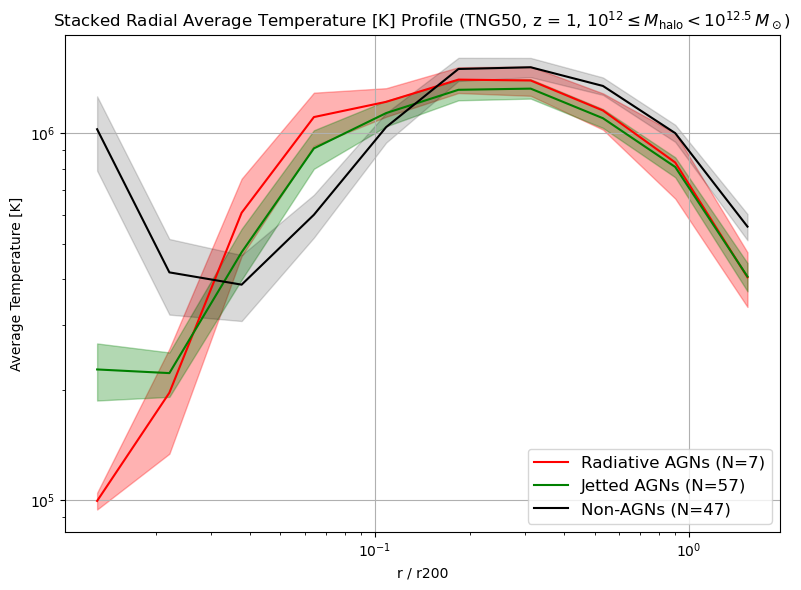

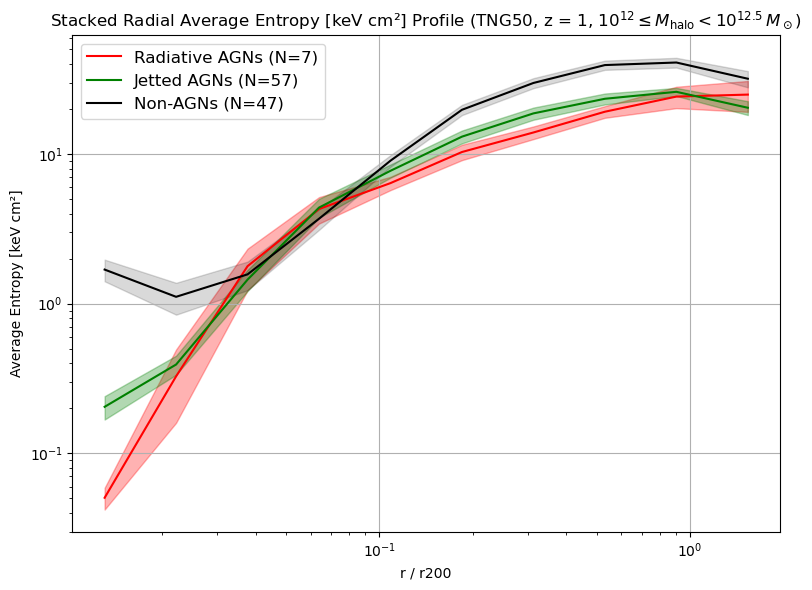

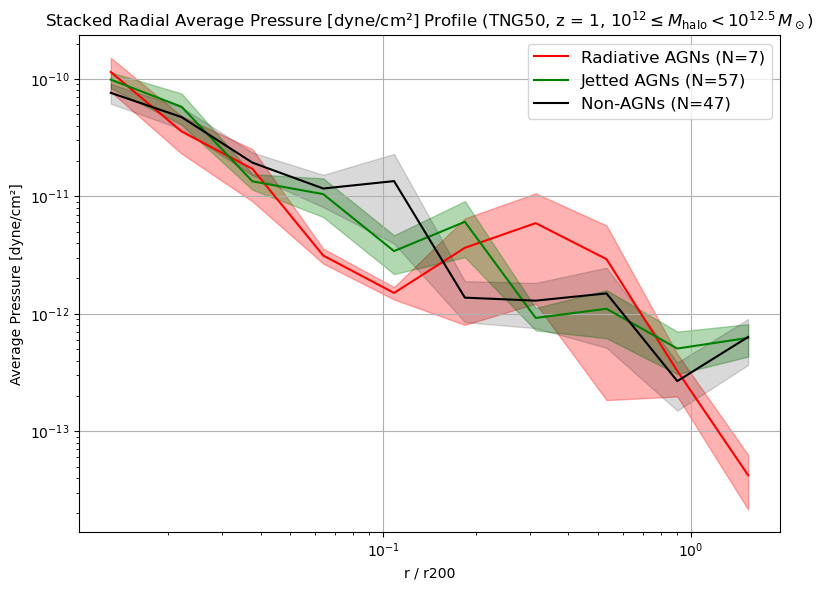

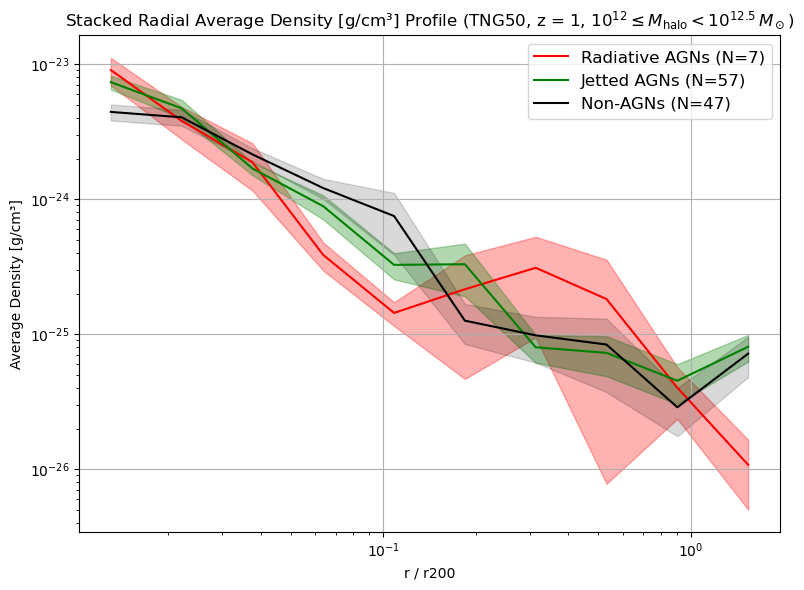

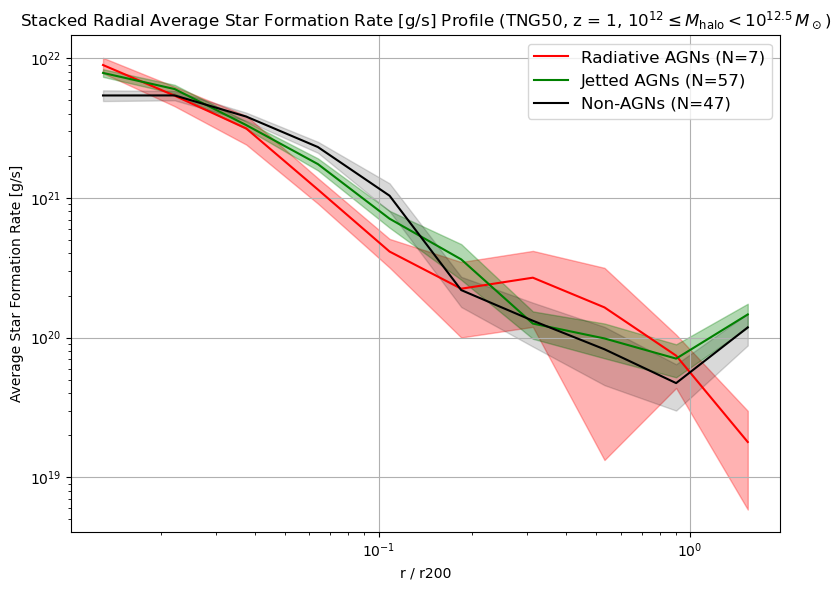

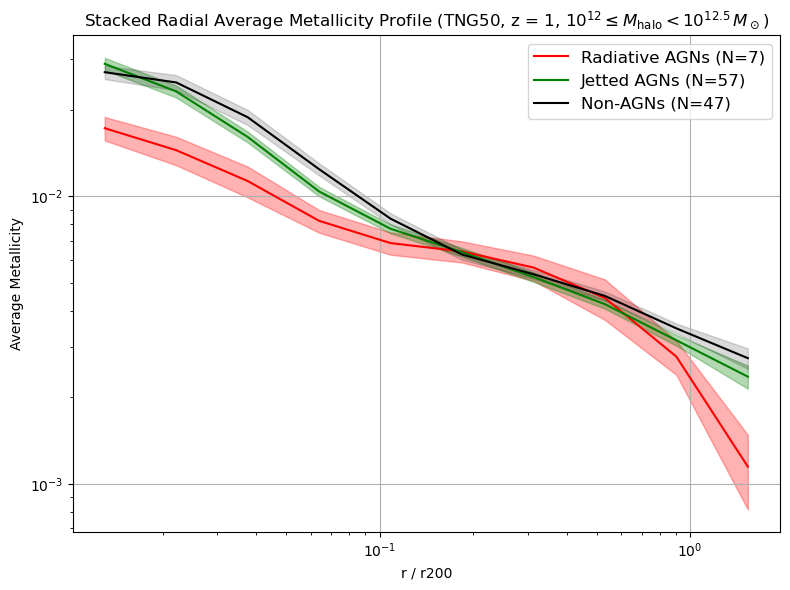

In [ ]:
# PART 5: Plot Thermodynamical Profiles (with 3 labels in each)

#bin_edges = np.linspace(0, r_norm_max, nbins + 1)
#bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

bin_edges = np.logspace(np.log10(1e-2), np.log10(r_norm_max), nbins + 1)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

hmv = ["1", "2", "3"]
#hm = "4"
hm = "3"
#hmn4 = r"$10^{12.5} \leq M_{\rm halo} < 10^{13} \, M_\odot$"
hmn3 =  r"$10^{12} \leq M_{\rm halo} < 10^{12.5} \, M_\odot$"
hmname = [
    r"$10^{11} \leq M_{\rm halo} < 10^{11.5} \, M_\odot$",
    r"$10^{11.5} \leq M_{\rm halo} < 10^{12} \, M_\odot$",
    r"$10^{12} \leq M_{\rm halo} < 10^{12.5} \, M_\odot$"  
]

#for hm, hmn in zip(hmv, hmname):
profiles_ha_agn = np.load(f"combined_hm{hm}_{tag[0]}.npz")
profiles_hn_agn = np.load(f"combined_hm{hm}_{tag[2]}.npz")
profiles_hn_non = np.load(f"combined_hm{hm}_{tag[3]}.npz")

data = np.load(f"accretor_agn50_hm{hm}.npz")          #ha_agn, ha_non, hn_agn, hn_non ids
ha_agn = data["ha_agn"]
hn_agn = data["hn_agn"]
hn_non = data["hn_non"]

def plot_quantity(quantity, ylabel, filename):

    avg_ha_agn = profiles_ha_agn[f"{quantity}_mean"]
    err_ha_agn = profiles_ha_agn[f"{quantity}_sem"]

    avg_hn_agn = profiles_hn_agn[f"{quantity}_mean"]
    err_hn_agn = profiles_hn_agn[f"{quantity}_sem"]

    avg_hn_non = profiles_hn_non[f"{quantity}_mean"]
    err_hn_non = profiles_hn_non[f"{quantity}_sem"]

    plt.figure(figsize=(8, 6))

    # Efficient Accretors - AGN
    plt.plot(bin_centers, avg_ha_agn.flatten(), label=f"Radiative AGNs (N={len(ha_agn)})", color="red")
    plt.fill_between(bin_centers, (avg_ha_agn - err_ha_agn).flatten(), (avg_ha_agn + err_ha_agn).flatten(),
                     color="red", alpha=0.3)


    # Inefficient Accretors - AGN
    plt.plot(bin_centers, avg_hn_agn.flatten(), label=f"Jetted AGNs (N={len(hn_agn)})", color="green")
    plt.fill_between(bin_centers, (avg_hn_agn - err_hn_agn).flatten(), (avg_hn_agn + err_hn_agn).flatten(),
                     color="green", alpha=0.3)

    # Inefficient Accretors - Non-AGN
    plt.plot(bin_centers, avg_hn_non.flatten(), label=f"Non-AGNs (N={len(hn_non)})", color="black")
    plt.fill_between(bin_centers, (avg_hn_non - err_hn_non).flatten(), (avg_hn_non + err_hn_non).flatten(),
                     color="black", alpha=0.15)

    plt.xlabel("r / r200")
    plt.ylabel(ylabel)
    plt.title(f"Stacked Radial {ylabel} Profile (TNG50, z = 1, {hmn3})")
    plt.legend(fontsize=12)
    plt.grid(True)
    #plt.xlim(1, 2)
    #plt.ylim(ylim)
    plt.xscale("log")
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig(filename, dpi=900)
    plt.show()

# Call the plot function for each physical quantity
plot_quantity("temperature", "Average Temperature [K]", f"temperature_{hm}.png")
plot_quantity("entropy", "Average Entropy [keV cm²]", f"entropy_{hm}.png")
plot_quantity("pressure", "Average Pressure [dyne/cm²]", f"pressure_{hm}.png")
plot_quantity("density", "Average Density [g/cm³]", f"density_{hm}.png")
plot_quantity("sfr", "Average Star Formation Rate [g/s]", f"sfr_{hm}.png")
plot_quantity("metal", "Average Metallicity", f"metal_{hm}.png")

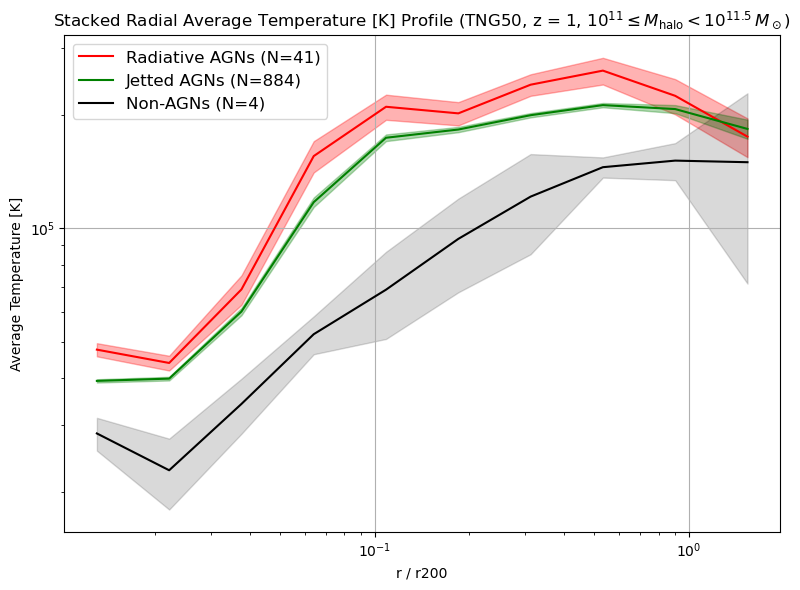

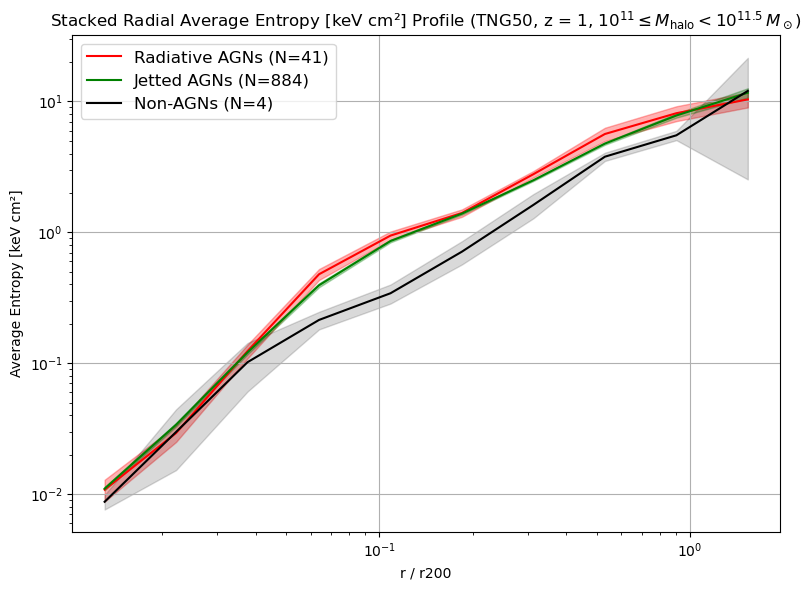

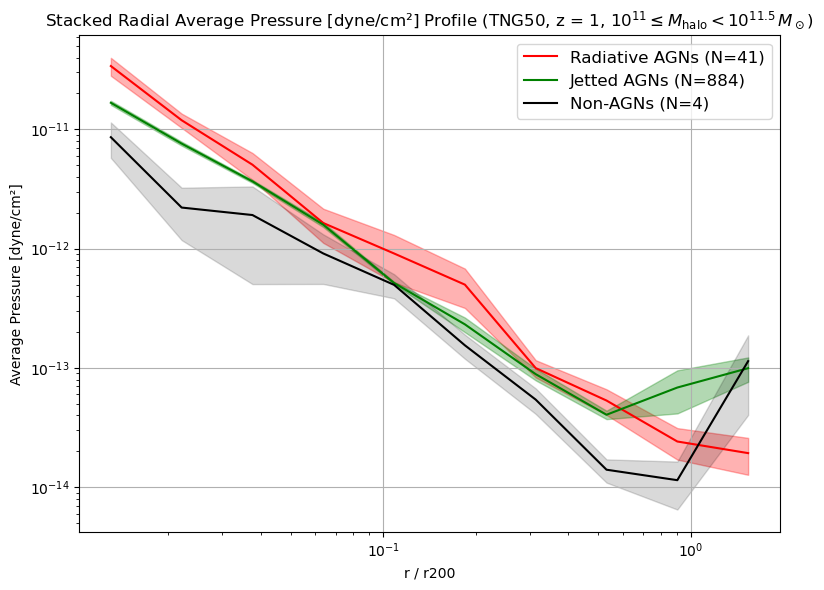

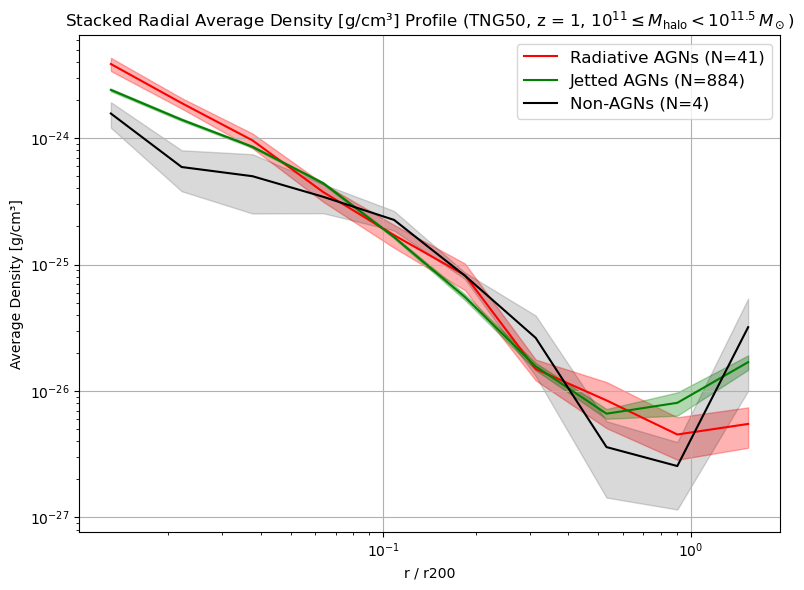

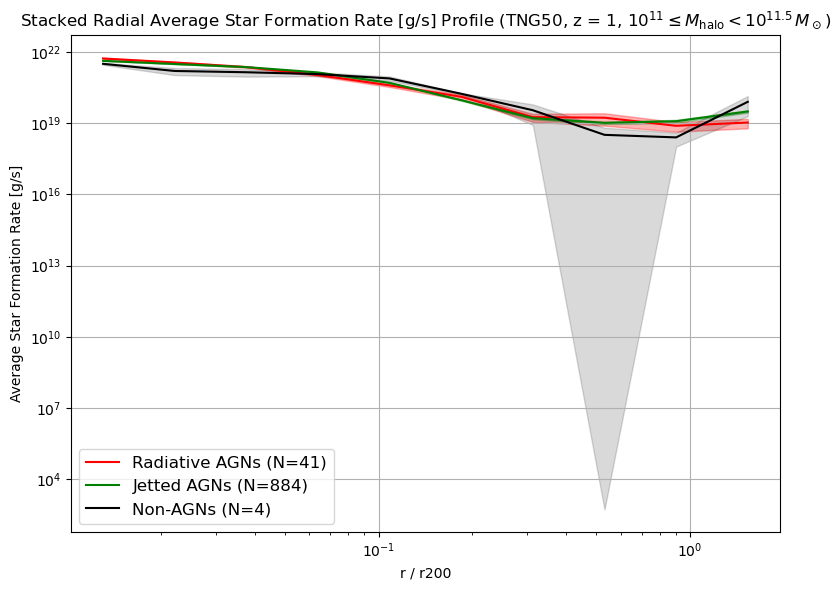

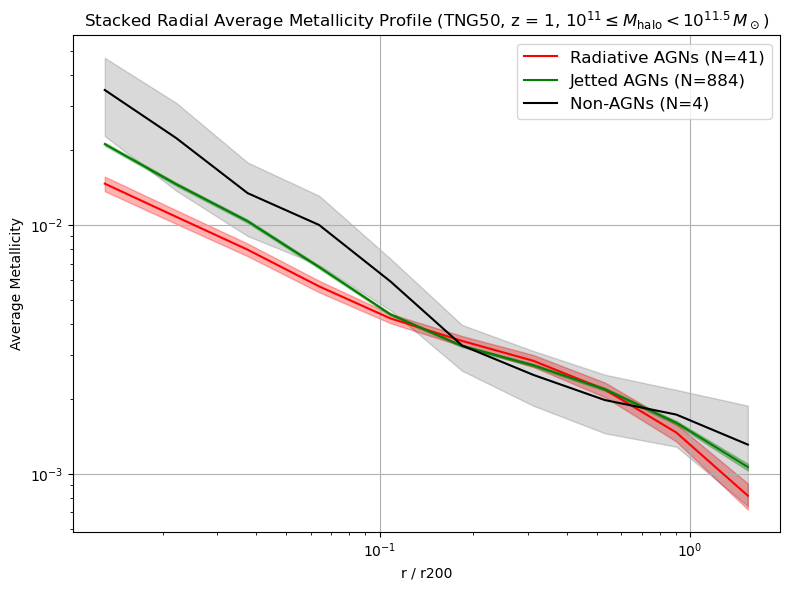

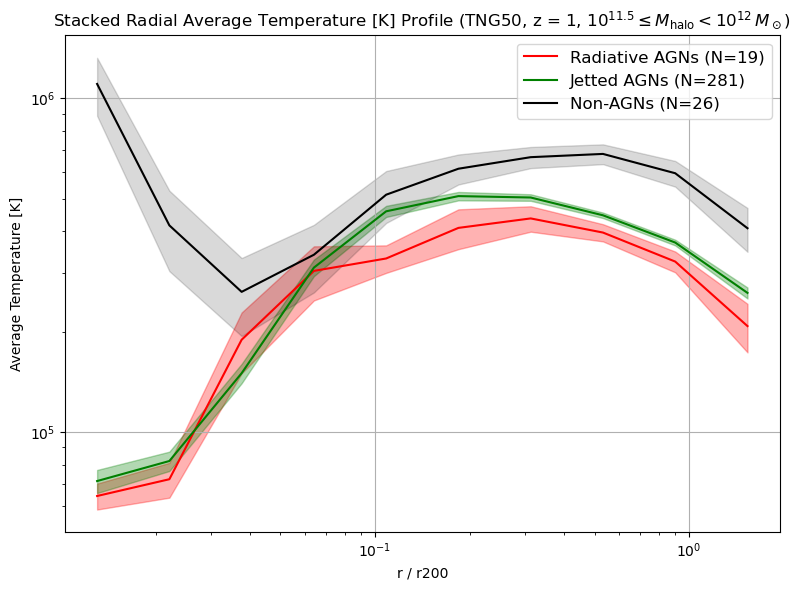

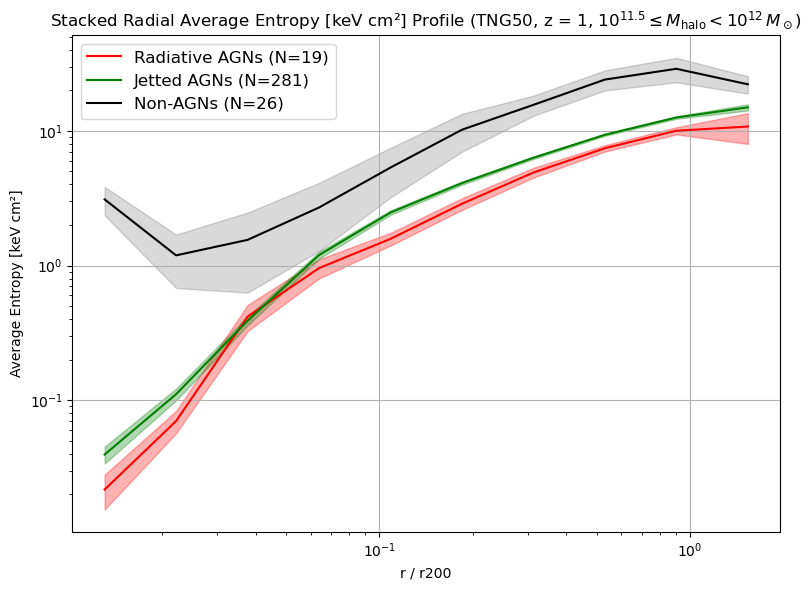

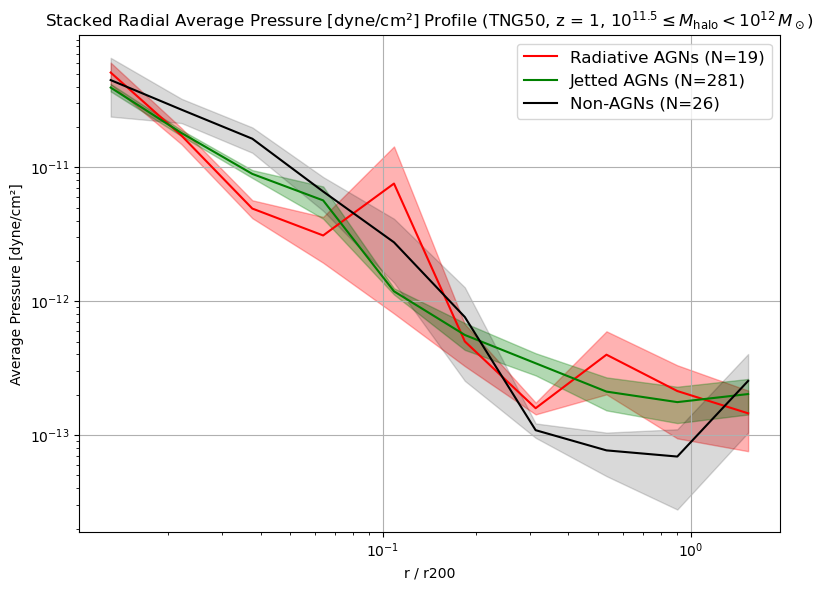

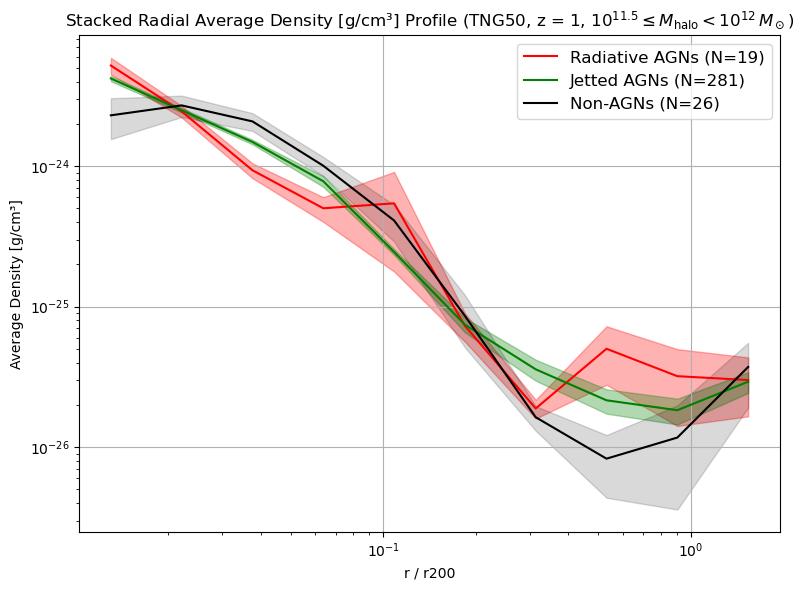

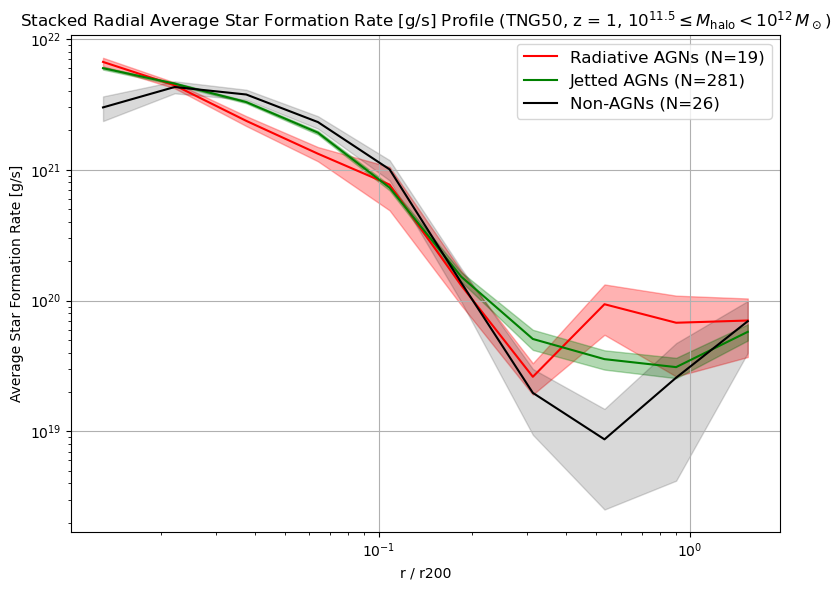

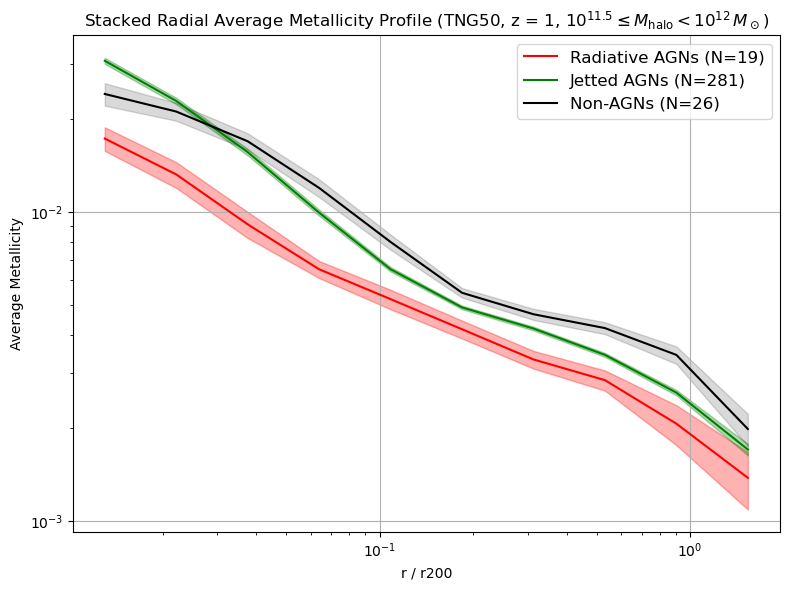

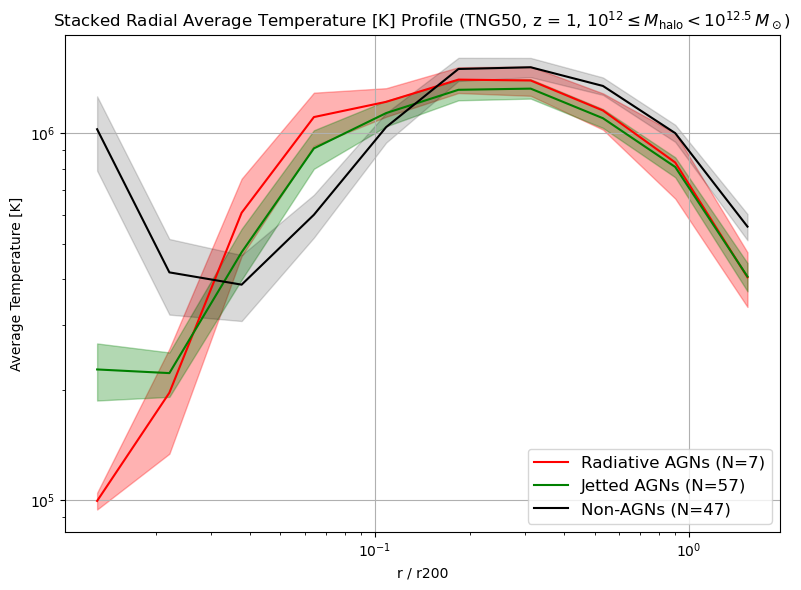

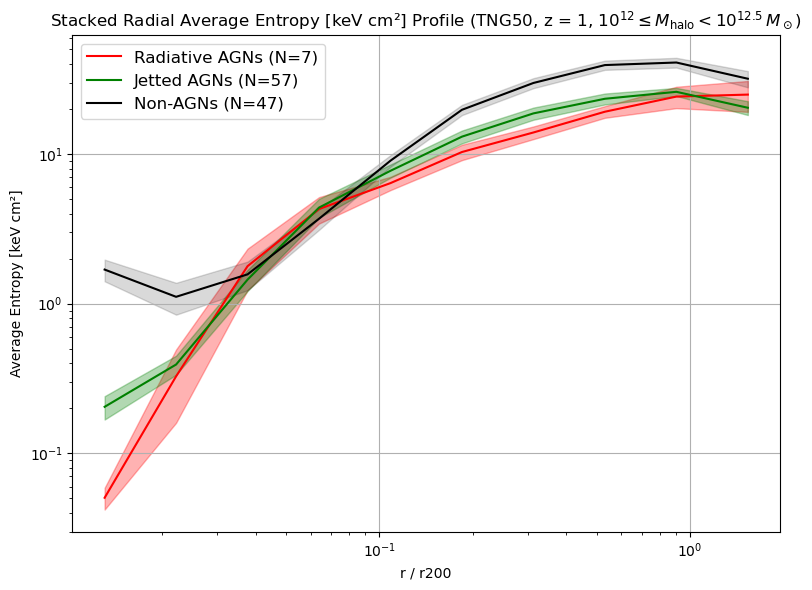

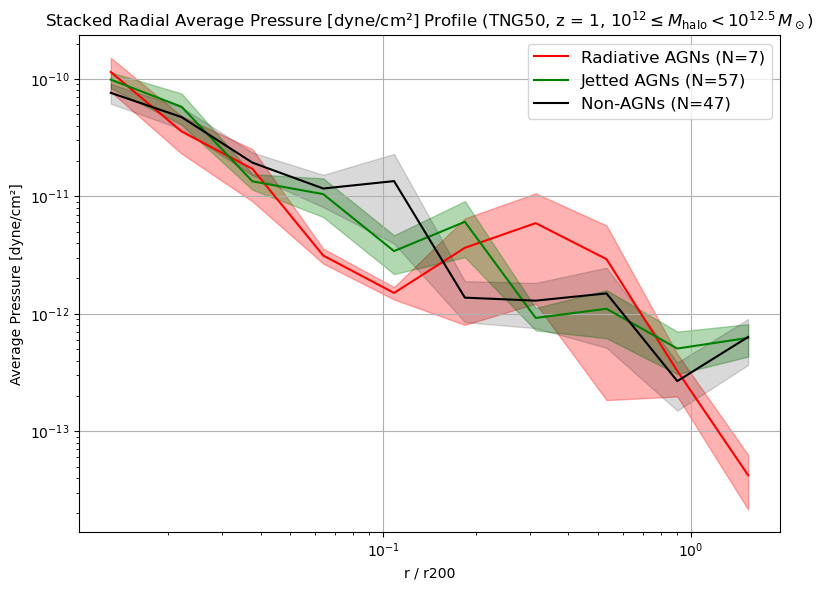

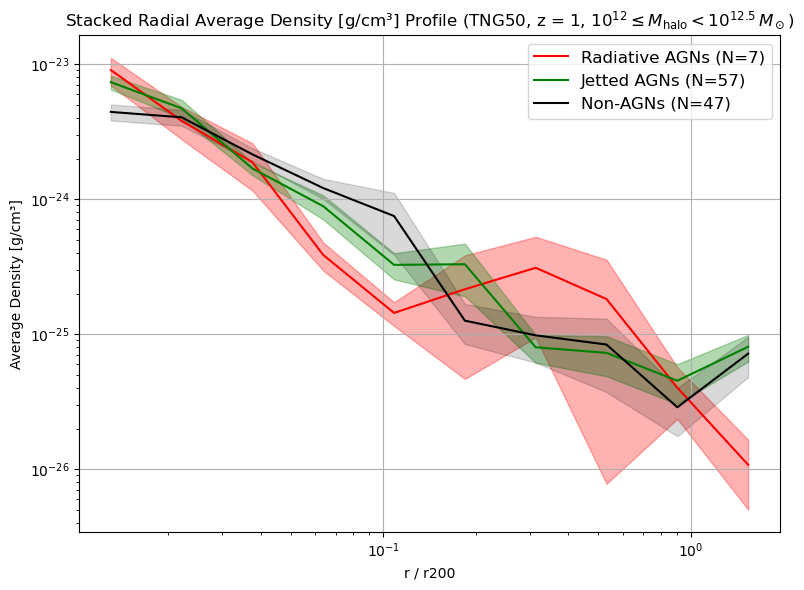

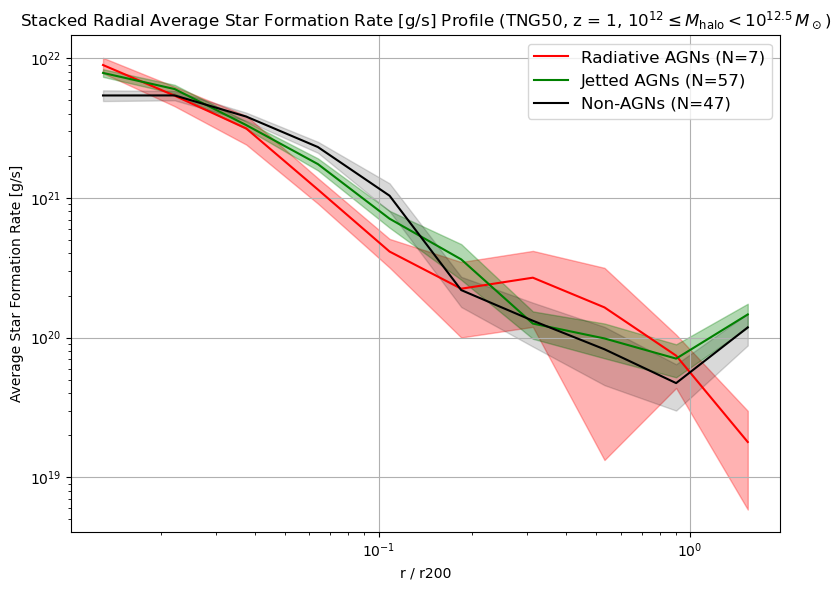

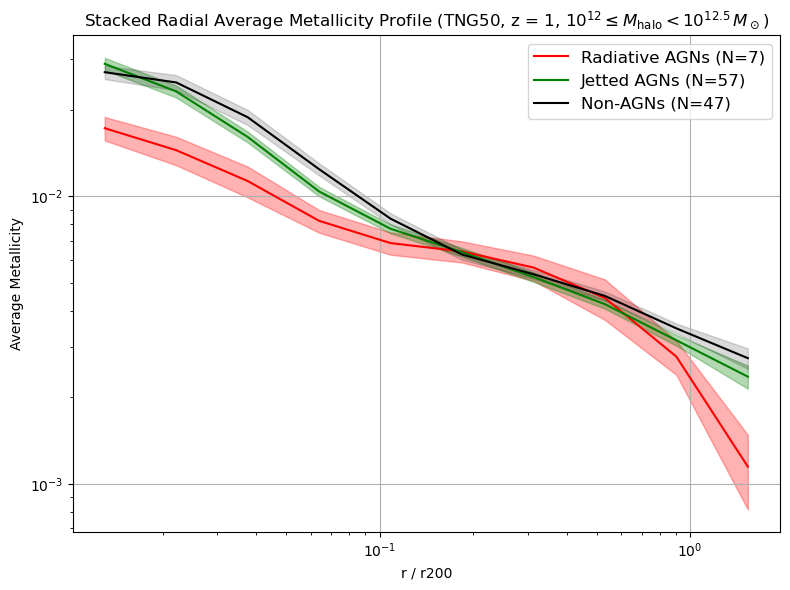

In [ ]:
# PART 5: Plot Thermodynamical Profiles (with 3 labels in each)
import numpy as np
import pylab as plt

#bin_edges = np.linspace(0, r_norm_max, nbins + 1)
#bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

bin_edges = np.logspace(np.log10(1e-2), np.log10(r_norm_max), nbins + 1)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

hmv = ["1", "2", "3"]

hmname = [
    r"$10^{11} \leq M_{\rm halo} < 10^{11.5} \, M_\odot$",
    r"$10^{11.5} \leq M_{\rm halo} < 10^{12} \, M_\odot$",
    r"$10^{12} \leq M_{\rm halo} < 10^{12.5} \, M_\odot$"  
]

for hm, hmn in zip(hmv, hmname):
    profiles_ha_agn = np.load(f"combined_hm{hm}_{tag[0]}.npz")
    profiles_hn_agn = np.load(f"combined_hm{hm}_{tag[2]}.npz")
    profiles_hn_non = np.load(f"combined_hm{hm}_{tag[3]}.npz")

    data = np.load(f"accretor_agn50_hm{hm}.npz")          #ha_agn, ha_non, hn_agn, hn_non ids
    ha_agn = data["ha_agn"]
    hn_agn = data["hn_agn"]
    hn_non = data["hn_non"]

    def plot_quantity(quantity, ylabel, filename):

        avg_ha_agn = profiles_ha_agn[f"{quantity}_mean"]
        err_ha_agn = profiles_ha_agn[f"{quantity}_sem"]

        avg_hn_agn = profiles_hn_agn[f"{quantity}_mean"]
        err_hn_agn = profiles_hn_agn[f"{quantity}_sem"]

        avg_hn_non = profiles_hn_non[f"{quantity}_mean"]
        err_hn_non = profiles_hn_non[f"{quantity}_sem"]

        plt.figure(figsize=(8, 6))

        # Efficient Accretors - AGN
        plt.plot(bin_centers, avg_ha_agn.flatten(), label=f"Radiative AGNs (N={len(ha_agn)})", color="red")
        plt.fill_between(bin_centers, (avg_ha_agn - err_ha_agn).flatten(), (avg_ha_agn + err_ha_agn).flatten(),
                         color="red", alpha=0.3)


        # Inefficient Accretors - AGN
        plt.plot(bin_centers, avg_hn_agn.flatten(), label=f"Jetted AGNs (N={len(hn_agn)})", color="green")
        plt.fill_between(bin_centers, (avg_hn_agn - err_hn_agn).flatten(), (avg_hn_agn + err_hn_agn).flatten(),
                         color="green", alpha=0.3)

        # Inefficient Accretors - Non-AGN
        plt.plot(bin_centers, avg_hn_non.flatten(), label=f"Non-AGNs (N={len(hn_non)})", color="black")
        plt.fill_between(bin_centers, (avg_hn_non - err_hn_non).flatten(), (avg_hn_non + err_hn_non).flatten(),
                         color="black", alpha=0.15)

        plt.xlabel("r / r200")
        plt.ylabel(ylabel)
        plt.title(f"Stacked Radial {ylabel} Profile (TNG50, z = 1, {hmn})")
        plt.legend(fontsize=12)
        plt.grid(True)
        #plt.xlim(1, 2)
        #plt.ylim(ylim)
        plt.xscale("log")
        plt.yscale("log")
        plt.tight_layout()
        plt.savefig(filename, dpi=900)
        plt.show()

    # Call the plot function for each physical quantity
    plot_quantity("temperature", "Average Temperature [K]", f"temperature_{hm}.png")
    plot_quantity("entropy", "Average Entropy [keV cm²]", f"entropy_{hm}.png")
    plot_quantity("pressure", "Average Pressure [dyne/cm²]", f"pressure_{hm}.png")
    plot_quantity("density", "Average Density [g/cm³]", f"density_{hm}.png")
    plot_quantity("sfr", "Average Star Formation Rate [g/s]", f"sfr_{hm}.png")
    plot_quantity("metal", "Average Metallicity", f"metal_{hm}.png")

puchii


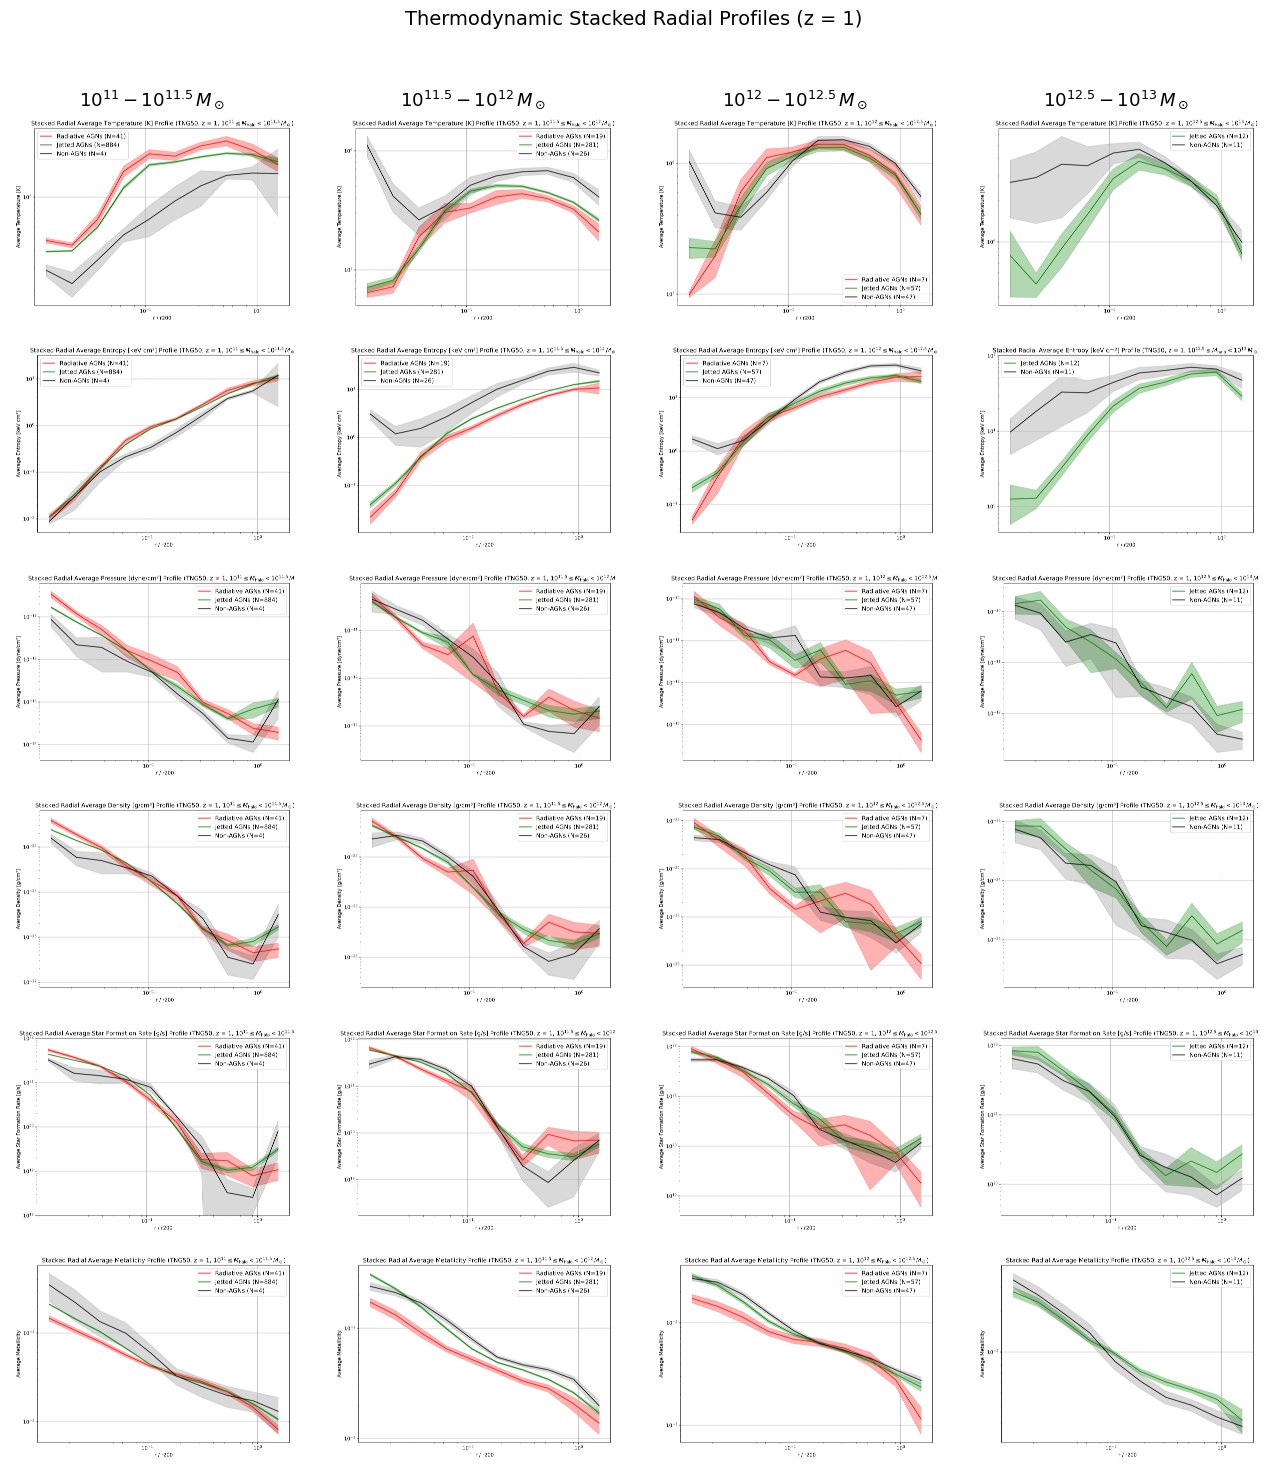

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

print("puchii")

quantities = ["temperature", "entropy", "pressure", "density", "sfr", "metal"]
hms = ["1", "2", "3", "4"]
hm_labels = [
    r"$10^{11} - 10^{11.5} \, M_\odot$",
    r"$10^{11.5} - 10^{12} \, M_\odot$",
    r"$10^{12} - 10^{12.5} \, M_\odot$",
    r"$10^{12.5} - 10^{13} \, M_\odot$"
]

fig, axes = plt.subplots(len(quantities), len(hms), figsize=(13, 15))

for i, quantity in enumerate(quantities):
    for j, hm in enumerate(hms):
        filename = f"{quantity}_{hm}.png"
        try:
            img = Image.open(filename)
            ax = axes[i, j]
            ax.imshow(np.asarray(img))
            ax.axis('off')
            if i == 0:
                ax.set_title(hm_labels[j], fontsize=13)
            if j == 0:
                ax.set_ylabel(quantity.capitalize(), fontsize=10)
        except Exception as e:
            print(f"Could not load {filename}: {e}")
            axes[i, j].axis('off')

# Add a super title
fig.suptitle("Thermodynamic Stacked Radial Profiles (z = 1)", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for supertitle
plt.savefig("tng50_4bins.pdf", dpi=1200)

plt.show()
